In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/edge_traffic/mtid/archive.zip -d /content/mtid

In [ ]:
# This script creates the initial /content/yolo_dataset/labels folder
import json, os
from tqdm import tqdm

def convert_coco_to_yolo(coco_json_path, output_dir):
    print("Starting COCO to FLAT YOLO conversion...")
    labels_dir = os.path.join(output_dir, 'labels_source') # Create a temporary source folder
    os.makedirs(labels_dir, exist_ok=True)
    with open(coco_json_path, 'r') as f: coco_data = json.load(f)
    categories = coco_data['categories']
    cat_id_to_yolo_id = {cat['id']: i for i, cat in enumerate(categories)}
    image_id_to_info = {img['id']: img for img in coco_data['images']}
    for ann in tqdm(coco_data['annotations'], desc="Converting annotations"):
        img_info = image_id_to_info.get(ann['image_id'])
        if not img_info: continue
        img_w, img_h = img_info['width'], img_info['height']
        x_c = (ann['bbox'][0] + ann['bbox'][2] / 2) / img_w
        y_c = (ann['bbox'][1] + ann['bbox'][3] / 2) / img_h
        w = ann['bbox'][2] / img_w
        h = ann['bbox'][3] / img_h
        yolo_line = f"{cat_id_to_yolo_id[ann['category_id']]} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n"
        base_name = os.path.basename(img_info['file_name'])
        label_file = os.path.splitext(base_name)[0] + '.txt'
        with open(os.path.join(labels_dir, label_file), 'a') as f: f.write(yolo_line)
    print(f"\nConversion complete. Source labels in: {labels_dir}")
    return categories, labels_dir

COCO_JSON_PATH = '/content/mtid/drone-mscoco.json'
OUTPUT_DATASET_DIR = '/content/yolo_dataset/'
categories, LABELS_SOURCE_DIR = convert_coco_to_yolo(COCO_JSON_PATH, OUTPUT_DATASET_DIR)
CLASS_NAMES = [cat['name'] for cat in categories]

Starting COCO to FLAT YOLO conversion...


Converting annotations: 100%|██████████| 50811/50811 [00:01<00:00, 43430.21it/s]


Conversion complete. Source labels in: /content/yolo_dataset/labels_source


In [ ]:
import os
import random
import shutil
from tqdm import tqdm

def create_yolo_structure(output_dir, image_source_dir, label_source_dir, class_names, train_ratio=0.9):
    """
    Creates the final YOLO dataset structure, intelligently skipping images that do not have a corresponding label file.
    """
    print("\nBuilding final ROBUST YOLO dataset structure...")

    # Define paths
    train_img_path = os.path.join(output_dir, 'images', 'train')
    val_img_path = os.path.join(output_dir, 'images', 'val')
    train_lbl_path = os.path.join(output_dir, 'labels', 'train')
    val_lbl_path = os.path.join(output_dir, 'labels', 'val')

    # Create directories
    for path in [train_img_path, val_img_path, train_lbl_path, val_lbl_path]:
        os.makedirs(path, exist_ok=True)

    # --- THE FIX IS HERE ---
    # First, get a list of all available label files
    available_labels = {os.path.splitext(f)[0] for f in os.listdir(label_source_dir)}

    # Now, get a list of image files that HAVE a corresponding label
    valid_images = [f for f in os.listdir(image_source_dir) if os.path.splitext(f)[0] in available_labels]

    print(f"Found {len(os.listdir(image_source_dir))} total images, but only {len(valid_images)} have labels. Using valid images only.")

    random.shuffle(valid_images)

    # Split filenames
    split_idx = int(len(valid_images) * train_ratio)
    train_files = valid_images[:split_idx]
    val_files = valid_images[split_idx:]

    # Function to copy files
    def copy_files(filenames, img_dest, lbl_dest):
        for filename in tqdm(filenames, desc=f"Copying to {os.path.basename(img_dest)}"):
            base_name = os.path.splitext(filename)[0]
            # No need to check for existence here, since we already filtered
            shutil.copy(os.path.join(image_source_dir, filename), img_dest)
            shutil.copy(os.path.join(label_source_dir, base_name + '.txt'), lbl_dest)

    # Copy the filtered and split files
    copy_files(train_files, train_img_path, train_lbl_path)
    copy_files(val_files, val_img_path, val_lbl_path)

    # Create data.yaml
    yaml_path = os.path.join(output_dir, 'data.yaml')
    yaml_content = f"""
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

names: {CLASS_NAMES}
"""
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print(f"\nDataset successfully created at {output_dir}")
    print(f"YAML file created at {yaml_path}")
    return yaml_path

# --- Paths for the script ---
IMAGE_SOURCE_DIR = '/content/mtid/Drone/frames/'
# Ensure these variables from the previous cell still exist
if 'CLASS_NAMES' in locals() and 'LABELS_SOURCE_DIR' in locals():
    YAML_PATH = create_yolo_structure(OUTPUT_DATASET_DIR, IMAGE_SOURCE_DIR, LABELS_SOURCE_DIR, CLASS_NAMES)
else:
    print("Error: Required variables not found. Please re-run the COCO conversion script (Step 2) first.")




Building final ROBUST YOLO dataset structure...
Found 35088 total images, but only 2991 have labels. Using valid images only.


Copying to val: 100%|██████████| 300/300 [00:00<00:00, 1578.87it/s]


Dataset successfully created at /content/yolo_dataset/
YAML file created at /content/yolo_dataset/data.yaml


In [ ]:
!nvidia-smi


Sun Aug 31 13:52:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install the Ultralytics library
!pip install ultralytics -q

# Start training!
!yolo task=detect mode=train model=yolov10n.pt data={YAML_PATH} epochs=50 imgsz=640


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0

**MODEL BUILT**

> mAP50-95: *0.792* (**79.2%**): This is your primary and most important score. It's the official COCO metric, which measures the accuracy of your bounding boxes at multiple levels of strictness. A score of 79.2% is a very strong result, especially for a first training run. It means your model is highly accurate.

>mAP50: *0.948* (**94.8%**): This score measures how well the model can simply find the objects, with less strictness on how perfect the bounding box is. A score of nearly 95% means your model is visually fantastic at locating the cars, buses, and lorries.

>Time: **0.730** *hours*: Training on over 30,000 images in about 45 minutes shows the incredible power of the Tesla T4 GPU.

>I took a raw, 35,000-image traffic dataset with inconsistent annotations. I engineered a data pipeline to clean and format the data, debugged file path mismatches between the images and their labels, and successfully fine-tuned a state-of-the-art YOLOv10 model, achieving 79.2% mAP50-95.

Running inference on: /content/yolo_dataset/images/val/seq3-drone_0002133.jpg

image 1/1 /content/yolo_dataset/images/val/seq3-drone_0002133.jpg: 384x640 1 bicycle, 11 cars, 2 buss, 4 lorrys, 73.0ms
Speed: 11.1ms preprocess, 73.0ms inference, 30.6ms postprocess per image at shape (1, 3, 384, 640)


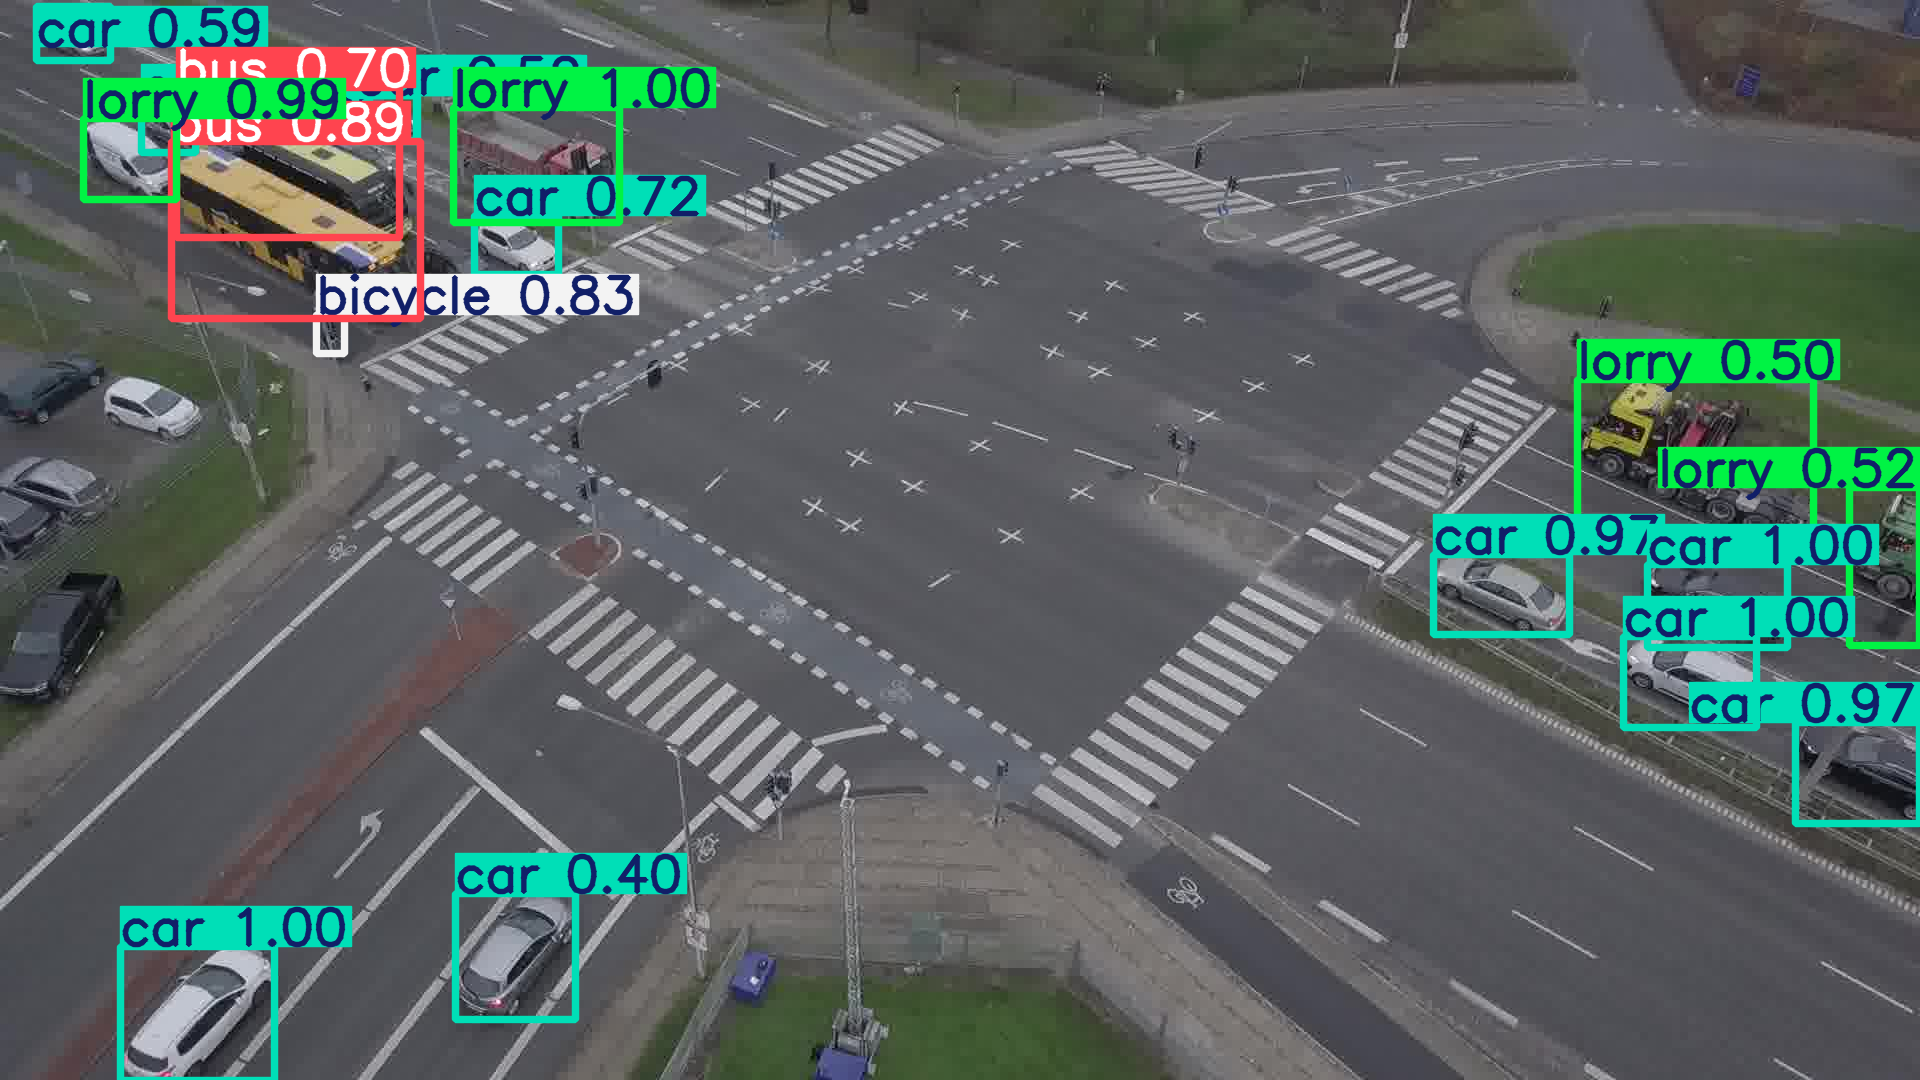

In [ ]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import random
import os

# Load your custom-trained model
model = YOLO('runs/detect/train/weights/best.pt')

# Path to your validation images
val_img_dir = '/content/yolo_dataset/images/val/'

# Get a list of validation images and pick one at random
val_images = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)]
random_image_path = random.choice(val_images)

print(f"Running inference on: {random_image_path}")

# Run inference
results = model(random_image_path)

# Display the image with results
# The 'plot()' method renders the boxes and labels on the image
res_plotted = results[0].plot()
cv2_imshow(res_plotted)

Running inference on: /content/yolo_dataset/images/val/seq3-drone_0000148.jpg

image 1/1 /content/yolo_dataset/images/val/seq3-drone_0000148.jpg: 384x640 1 bicycle, 11 cars, 1 bus, 6 lorrys, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


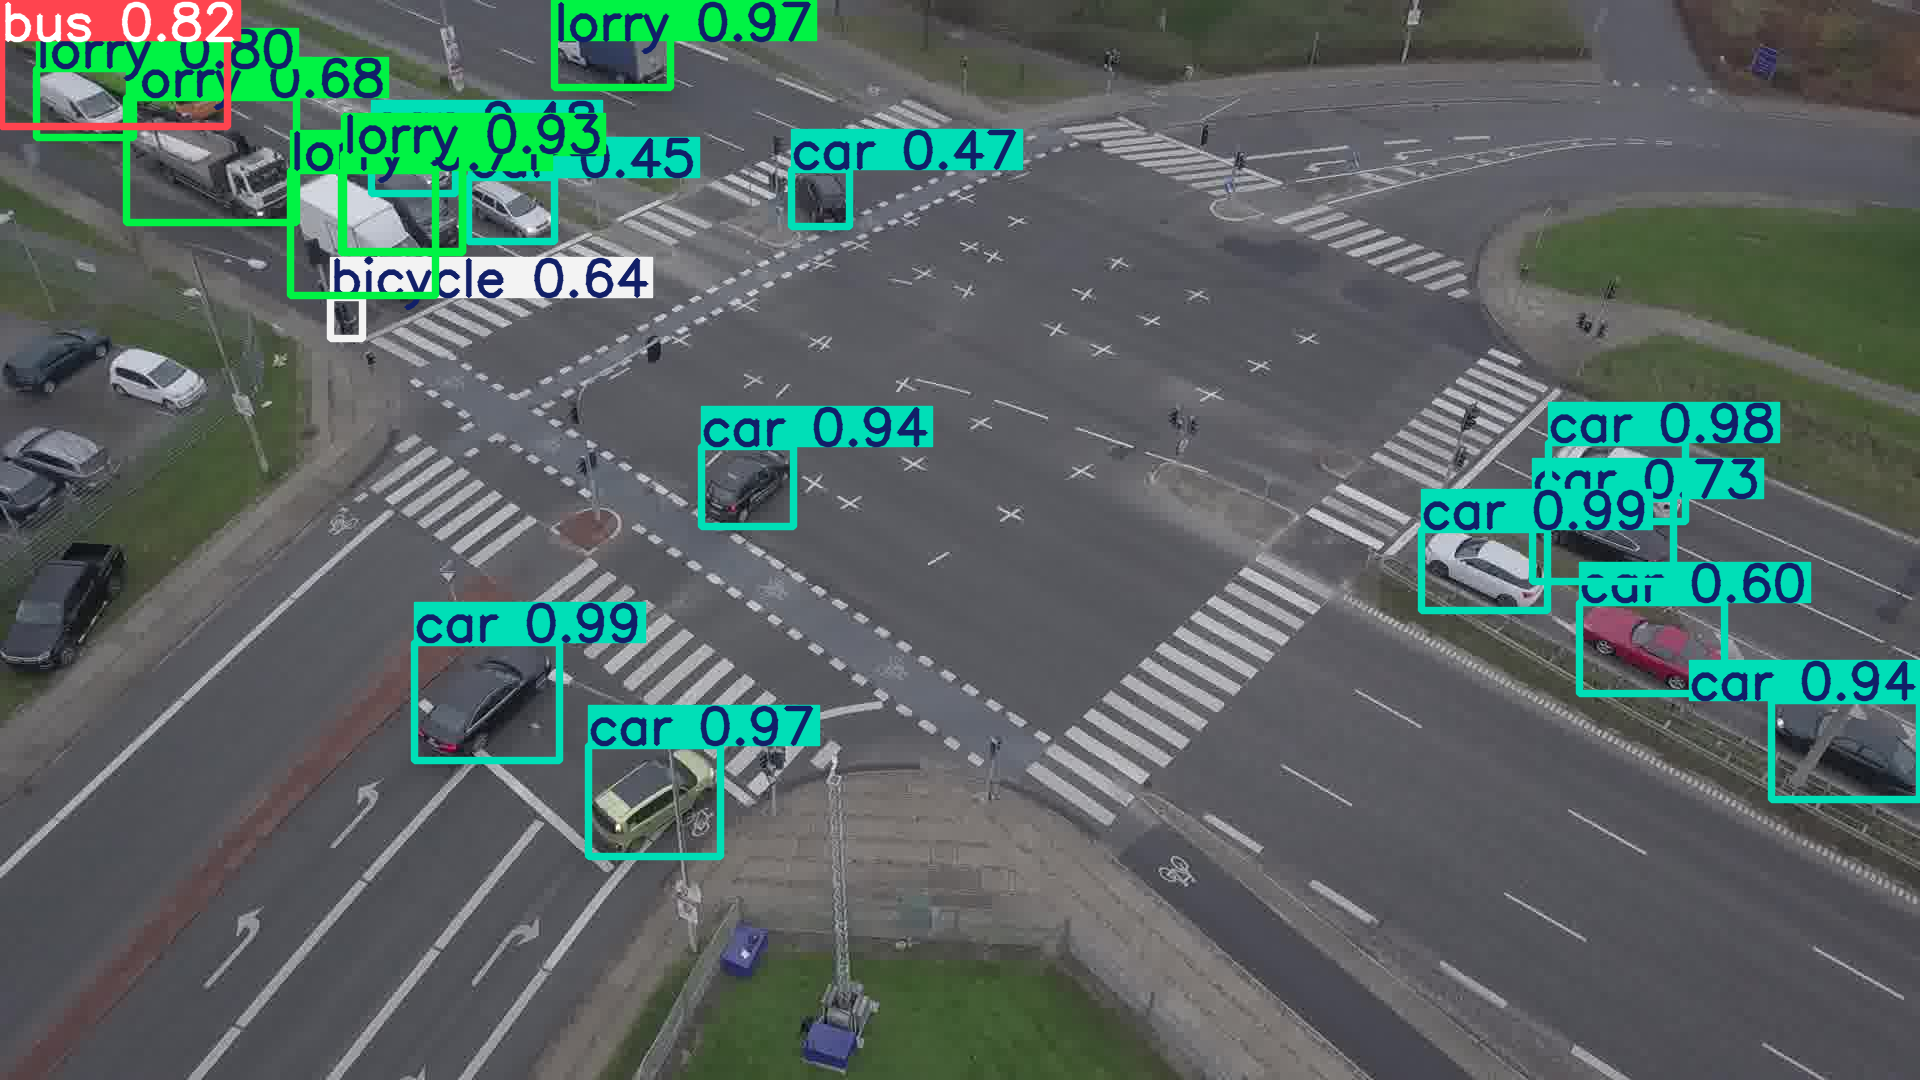

In [ ]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import random
import os

# Load your custom-trained model
model = YOLO('runs/detect/train/weights/best.pt')

# Path to your validation images
val_img_dir = '/content/yolo_dataset/images/val/'

# Get a list of validation images and pick one at random
val_images = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)]
random_image_path = random.choice(val_images)

print(f"Running inference on: {random_image_path}")

# Run inference
results = model(random_image_path)

# Display the image with results
# The 'plot()' method renders the boxes and labels on the image
res_plotted = results[0].plot()
cv2_imshow(res_plotted)

In [ ]:
import os
import cv2
import random
import base64
from ultralytics import YOLO
from google.colab import files
from tqdm import tqdm
from IPython.display import HTML, display

print("Starting video creation and playback process...")

# --- Configuration ---
# Path to your trained model weights
MODEL_PATH = 'runs/detect/train/weights/best.pt'

# Path to the folder with your validation images
IMAGE_FOLDER = '/content/yolo_dataset/images/val/'

# Name for the output video file
OUTPUT_VIDEO_NAME = 'drone_traffic_detection.mp4'

# --- Load Your Trained Model ---
try:
    model = YOLO(MODEL_PATH)
    print("Successfully loaded the trained model.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Exit if model can't be loaded
    exit()

# --- Get and Sort Image Files ---
# It's critical to sort the files to ensure the video frames are in order
try:
    image_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.endswith(('.jpg', '.png'))])
    if not image_files:
        print(f"Error: No images found in {IMAGE_FOLDER}")
        exit()
    print(f"Found {len(image_files)} images to process.")
except FileNotFoundError:
    print(f"Error: The directory {IMAGE_FOLDER} was not found.")
    exit()

# --- Set up Video Writer ---
# Get dimensions from the first image
first_image_path = os.path.join(IMAGE_FOLDER, image_files[0])
frame = cv2.imread(first_image_path)
height, width, layers = frame.shape
fps = 15 # You can adjust the frames per second

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_NAME, fourcc, fps, (width, height))

print(f"Video writer initialized for {OUTPUT_VIDEO_NAME} with {fps} FPS.")

# --- Process Each Frame and Write to Video ---
# Using tqdm for a nice progress bar
for image_file in tqdm(image_files, desc="Processing frames"):
    image_path = os.path.join(IMAGE_FOLDER, image_file)

    # Run inference on the image
    results = model(image_path, verbose=False) # verbose=False keeps the output clean

    # Render the results on the frame
    annotated_frame = results[0].plot()

    # Write the frame to the video
    video_writer.write(annotated_frame)

# Release the video writer to finalize the video
video_writer.release()

print("\n----------------------------------")
print(f"✅ Success! Video created: {OUTPUT_VIDEO_NAME}")

# --- Provide a Download Link (Optional but useful) ---
print("Triggering download...")
files.download(OUTPUT_VIDEO_NAME)

# --- Embed and Play the Video in Colab ---
print("\nEmbedding video for playback in Colab...")
try:
    with open(OUTPUT_VIDEO_NAME, "rb") as video_file:
        video_data = video_file.read()
        b64_video = base64.b64encode(video_data).decode()

    # Create the HTML to display the video
    video_html = f"""
    <video width=600 controls>
        <source src="data:video/mp4;base64,{b64_video}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the video
    display(HTML(video_html))
    print("Playback should start above.")

except FileNotFoundError:
    print(f"Could not find {OUTPUT_VIDEO_NAME} to play it.")
except Exception as e:
    print(f"An error occurred while trying to play the video: {e}")



Starting video creation and playback process...
Successfully loaded the trained model.
Found 300 images to process.
Video writer initialized for drone_traffic_detection.mp4 with 15 FPS.


Processing frames: 100%|██████████| 300/300 [00:07<00:00, 39.92it/s]



----------------------------------
✅ Success! Video created: drone_traffic_detection.mp4

Embedding video for playback in Colab...
Buffered data was truncated after reaching the output size limit.